In [2]:
from extra_data import RunDirectory 
import h5py 
import numpy as np 
import matplotlib.pyplot as plt 
PREFIX='/gpfs/exfel/exp/SPB/202202/p003046'


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray
import scipy.optimize
from scipy import signal
import seaborn as sns

# Apply the default theme
sns.set()

In [4]:
import xarray
read_cache = {}

def read_run_sync_trains(r, verbose=True, cache=True, use_cache=True):
    global read_cache
    if r in read_cache and use_cache:
        return read_cache[r]
    #clear_output(wait=False) 
    #sys.stderr.write(f'Processing run {r}...\n') 
    run = RunDirectory(path='/pnfs/xfel.eu/exfel/archive/XFEL/raw/SPB/202202/p003046/r%04d' % (r))  
    
    # The require_all=True ensures we only get trains which exist for all sources
    sel = run.select([
        ('SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD'),
        ('SA1_XTD2_XGM/XGM/DOOCS:output', 'data.intensitySa1TD'),
        ('SPB_IRU_MOTORS/MDL/DATA_SELECT', '*'),
        ('SPB_EXP_ZYLA/CAM/1:daqOutput', 'data.image.pixels'),
    ], require_all=True)
    if(verbose):
        sel.info()
    
    intensity_sase1_extra = sel['SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD']
    intensity_preattenuator_sase1_extra = sel['SA1_XTD2_XGM/XGM/DOOCS:output', 'data.intensitySa1TD']    
    motors_x_extra = sel['SPB_IRU_MOTORS/MDL/DATA_SELECT', 'SPB_IRU_INJMOV_MOTOR_X.actualPosition.value']
    motors_y_extra = sel['SPB_IRU_MOTORS/MDL/DATA_SELECT', 'SPB_IRU_INJMOV_MOTOR_Y.actualPosition.value']
    sidemic_extra = sel['SPB_EXP_ZYLA/CAM/1:daqOutput', 'data.image.pixels']

    # Put the data in xarray
    motor_x = motors_x_extra.xarray()
    motor_y = motors_y_extra.xarray()
    xgm = intensity_sase1_extra.xarray()
    xgm2 = intensity_preattenuator_sase1_extra.xarray()
    sidemic = sidemic_extra.xarray()
    
    directory = '/gpfs/exfel/u/scratch/SPB/202202/p003046/data' 
    agipd_frames_per_train = 202 # number of agipd frames per train
    with h5py.File(directory+'/r%04d_proc_radavg.h5' % (r)) as rad: 
        radavg = rad['entry_1']['radialavg'][:]
        trainIds = rad['entry_1']['trainId'][:]
        radcount = rad['entry_1']['radialcount'][:]
        q = rad['entry_1']['q'][:]

    with h5py.File(directory+'/r%04d_proc_laser.h5' % (r)) as rad: 
        laser_on = rad['entry_1']['laser_on'][:]
        trainIds_laser = rad['entry_1']['trainId'][:]
        
 
        
    # Reshape the arrays from the radavg file to make them by train
    radavg = radavg.reshape((-1,agipd_frames_per_train,radavg.shape[1]))
    radcount = radcount.reshape((-1,agipd_frames_per_train,radcount.shape[1]))
    trainIds = trainIds.reshape((-1,agipd_frames_per_train))
    
    # Ensure all the trains are the same length
    if (trainIds == trainIds[:,:1]).all() != True:
        raise ValueError        
    if(verbose):
        print("Reshaping of radavg successful:", (trainIds == trainIds[:,:1]).all())
    trainIds = trainIds[:,0]
    
    # Put radavg in an xarray
    radavg = xarray.DataArray(data=radavg, dims=('trainId', 'pulseNr', 'q'), 
                              coords={'trainId': trainIds, 'pulseNr': np.arange(agipd_frames_per_train), 'q': q})
    radcount = xarray.DataArray(data=radcount, dims=('trainId', 'pulseNr', 'q'), 
                              coords={'trainId': trainIds, 'pulseNr': np.arange(agipd_frames_per_train), 'q': q})
    
    # Put laser_on in an xarray
    laser = xarray.DataArray(data=laser_on, dims=('trainId'), 
                              coords={'trainId': trainIds_laser})

    # Find trains which are common between radavg and the rest
    common_trains = np.intersect1d(intensity_sase1_extra.train_id_coordinates(), np.intersect1d(trainIds, trainIds_laser))
    if verbose:
        print("Found %d common train IDs between radavg and the rest" % len(common_trains))

    # Find the indices of the common trainIds and keep only those
    common_train_idx = np.searchsorted(intensity_sase1_extra.train_id_coordinates(),common_trains)
    motor_x = motor_x[common_train_idx]
    motor_y = motor_y[common_train_idx]
    xgm = xgm[common_train_idx]

    # Find the indices of the common trainIds for radavg    
    common_train_idx = np.searchsorted(radavg.coords['trainId'].data,common_trains)
    radavg = radavg[common_train_idx]
    radcount = radcount[common_train_idx]

    # Find the indices of the common trainIds for laser_on    
    common_train_idx = np.searchsorted(laser.coords['trainId'].data,common_trains)
    laser = laser[common_train_idx]
    
    train_ids_eq = (motor_x.coords['trainId'].data == radavg.coords['trainId'].data) * (motor_x.coords['trainId'].data == laser.coords['trainId'].data)
    if verbose:
        print("Train IDs all match:", train_ids_eq.all())
    if(cache):
        read_cache[r] = (xgm, motor_x, motor_y, radavg, xgm2, sidemic, laser, radcount)
    return xgm, motor_x, motor_y, radavg, xgm2, sidemic, laser, radcount

In [34]:
def noise_floor(run, figure=None, show_noise=True, corr_thres = None, norm_q_range = None, pixel_count_norm=True):
    radavg, radcount, laser, good_trains, good_pulses = filtered_run(run, corr_thres = corr_thres)        

    laser_off = (laser == False)*good_trains
    laser_on = (laser == True)*good_trains

    q = radavg.coords['q'].data
    
    if norm_q_range is not None:
        norm_q_slice = slice(np.argmax(q > norm_q_range[0]), np.argmax(q > norm_q_range[1]))    
    else:
        norm_q_slice = slice(None,None)
        
    print("Normalization slice - ",norm_q_slice)
        
    if figure is None:
        plt.figure(figsize=(12,4))    
    
    laser_off_per_q = np.nanmean(radavg[(laser == False)*good_trains,good_pulses],axis=(0,1))
    if(pixel_count_norm):        
        pixel_count_factor = radcount[0,0]/np.nanmean(radcount[0,0])
    else:
        pixel_count_factor = 1
    laser_off_I = np.nansum((laser_off_per_q*pixel_count_factor)[norm_q_slice])
    laser_on_q = np.nanmean(radavg[(laser == True)*good_trains,good_pulses],axis=(0,1))
    laser_on_I = np.nansum((laser_on_q*pixel_count_factor)[norm_q_slice])
    
    laser_on_q_norm = laser_on_q/laser_on_I
    laser_off_q_norm = laser_off_per_q/laser_off_I
    
    plt.plot(q, (laser_on_q_norm - laser_off_q_norm), label='Run %d Signal' % run)
    plt.ylim([-5e-6,5e-6])
    #ax2 = plt.gca().twinx()
    #ax2.plot(q, laser_on_q_norm, label='Run %d Laser On' % run)
    #ax2.plot(q, laser_off_q_norm, label='Run %d Laser Off' % run)
    #ax2.plot(q, radcount[0,0]/1000000, label='MPixels per q')
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.tight_layout()    
    return q, laser_on_q_norm, laser_off_q_norm, good_trains.sum()

In [19]:
def good_buffer_runs(error_thres = 1e-4, corr_thres=0.99995):
    all_buffer_runs = 133,135,141,142,146,156,160
    fig = plt.figure(figsize=(12,4)) 
    good_runs = []
    for run in all_buffer_runs:
        q, laser_on_q_norm, laser_off_q_norm, good_trains = noise_floor(run, figure=fig, show_noise=False, corr_thres=corr_thres)
        mean_error = np.nansum(np.abs(laser_on_q_norm-laser_off_q_norm))
        if mean_error < error_thres:
            good_runs.append(run)
        print(run, mean_error)
    return good_runs
        
        

In [42]:
def I_buff(corr_thres=0.99995, cache=True, use_cache=True):
    global read_cache
    if 'I_buff' in read_cache and use_cache:
        return read_cache['I_buff']
    buffer_runs = good_buffer_runs(corr_thres=corr_thres)
    I_buff = None
    I_buff_count = None
    shots = 0
    for run in buffer_runs:
        radavg, radcount, laser, good_trains, good_pulses = filtered_run(run, corr_thres = corr_thres)
        q = radavg.coords['q'].data
        shots += np.sum(good_trains)*np.sum(good_pulses)
        if I_buff is None:
            I_buff = np.nansum(radavg[good_trains,good_pulses],axis=(0,1))
            I_buff_count = np.nansum(radcount[good_trains,good_pulses],axis=(0,1))
        else:
            I_buff += np.nansum(radavg[good_trains,good_pulses],axis=(0,1))
            I_buff_count += np.nansum(radcount[good_trains,good_pulses],axis=(0,1))
    I_buff /= shots
    I_buff_count /= shots
    if cache:
        read_cache['I_buff'] = I_buff
    return I_buff

In [129]:
def remove_I_buff(I):
    import scipy.optimize
    scipy.optimize.minimize_scalar
    if (I.ndim > 1):
        Ip = np.zeros_like(I)
        for p in range(I.shape[0]):
            res = scipy.optimize.minimize_scalar(lambda x: np.nansum(np.abs(x*I[p]-I_buff())))
            Ip[p] = I[p]*res.x-I_buff()
    else:
        res = scipy.optimize.minimize_scalar(lambda x: np.nansum(np.abs(x*I-I_buff())))
        Ip = I*res.x-I_buff()        
    return Ip

In [104]:
def I_on_off(runs, corr_thres=0.99995):
    I_on = None
    I_on_count = None
    I_off = None
    I_off_count = None    
    shots_on = 0
    shots_off = 0
    for run in runs:
        radavg, radcount, laser, good_trains, good_pulses = filtered_run(run, corr_thres = corr_thres)
        # Don't take runs with less than 75% good trains
        if np.nanmean(good_trains) < 0.75:
            continue
        q = radavg.coords['q'].data
        
        shots_off += np.sum((laser.data == False)*good_trains)*np.sum(good_pulses)
        shots_on += np.sum((laser.data == True)*good_trains)*np.sum(good_pulses)
        if I_off is None:
            I_off = np.nansum(radavg[(laser == False)*good_trains,good_pulses],axis=(0))
            I_off_count = np.nansum(radcount[(laser == False)*good_trains,good_pulses],axis=(0))
            
            I_on = np.nanmean(radavg[(laser == True)*good_trains,good_pulses],axis=(0))            
            I_on_count = np.nansum(radcount[(laser == True)*good_trains,good_pulses],axis=(0))
        else:
            I_off += np.nansum(radavg[(laser == False)*good_trains,good_pulses],axis=(0))
            I_off_count += np.nansum(radcount[(laser == False)*good_trains,good_pulses],axis=(0))
            I_on += np.nanmean(radavg[(laser == True)*good_trains,good_pulses],axis=(0))            
            I_on_count += np.nansum(radcount[(laser == True)*good_trains,good_pulses],axis=(0))
    I_off /= shots_off
    I_on /= shots_on
    I_off_count /= shots_off
    I_on_count /= shots_on
    return I_on, I_off

In [105]:
I_on, I_off = I_on_off(np.arange(167, 181))

Kept 2778 out of 3121 trains
Kept 2777 out of 3121 trains
Kept 2022 out of 3125 trains
Kept 2021 out of 3125 trains
Kept 50 out of 3126 trains
Kept 50 out of 3126 trains
Kept 0 out of 3118 trains
Kept 0 out of 3118 trains
Kept 2931 out of 3125 trains
Kept 2930 out of 3125 trains
Kept 2837 out of 3122 trains
Kept 2837 out of 3122 trains
Kept 896 out of 3121 trains
Kept 896 out of 3121 trains
Kept 3016 out of 3125 trains
Kept 3015 out of 3125 trains
Kept 3023 out of 3118 trains
Kept 3023 out of 3118 trains
Kept 2948 out of 3123 trains
Kept 2947 out of 3123 trains
Kept 413 out of 3125 trains
Kept 413 out of 3125 trains
Kept 0 out of 3121 trains
Kept 0 out of 3121 trains
Kept 118 out of 3126 trains
Kept 118 out of 3126 trains
Kept 0 out of 3126 trains
Kept 0 out of 3126 trains


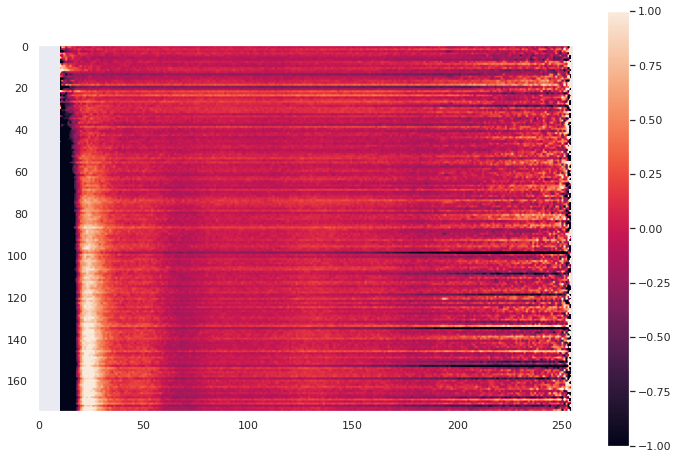

In [140]:
plt.figure(figsize=(12,8))
plt.grid(None)
plt.imshow(remove_I_buff(I_on)-remove_I_buff(I_off), vmax=1,vmin=-1)
plt.colorbar()

In [141]:
np.savetxt("runs_167-180_I_pon-I_poff.csv", remove_I_buff(I_on)-remove_I_buff(I_off), delimiter=",")
np.savetxt("runs_167-180_I_poff.csv", remove_I_buff(I_off), delimiter=",")
np.savetxt("runs_167-180_I_pon.csv", remove_I_buff(I_on), delimiter=",")
np.savetxt("runs_167-180_I_off.csv", I_off, delimiter=",")
np.savetxt("runs_167-180_I_on.csv", I_on, delimiter=",")

In [142]:
I_on, I_off = I_on_off([136, 137, 138, 139, 140, 149, 150, 151, 152, 155, 157, 158, 164, 165])

Kept 2953 out of 3122 trains
Kept 2952 out of 3122 trains
Kept 2974 out of 3127 trains
Kept 2974 out of 3127 trains
Kept 2895 out of 3123 trains
Kept 2894 out of 3123 trains
Kept 0 out of 3129 trains
Kept 0 out of 3129 trains
Kept 0 out of 1752 trains
Kept 0 out of 1752 trains
Kept 1930 out of 3123 trains
Kept 1930 out of 3123 trains
Kept 0 out of 3110 trains
Kept 0 out of 3110 trains
Kept 3009 out of 3124 trains
Kept 3008 out of 3124 trains
Kept 3013 out of 3120 trains
Kept 3013 out of 3120 trains
Kept 3012 out of 3117 trains
Kept 3011 out of 3117 trains
Kept 3077 out of 3120 trains
Kept 3077 out of 3120 trains
Kept 0 out of 3123 trains
Kept 0 out of 3123 trains
Kept 3024 out of 3117 trains
Kept 3024 out of 3117 trains
Kept 2907 out of 3116 trains
Kept 2906 out of 3116 trains


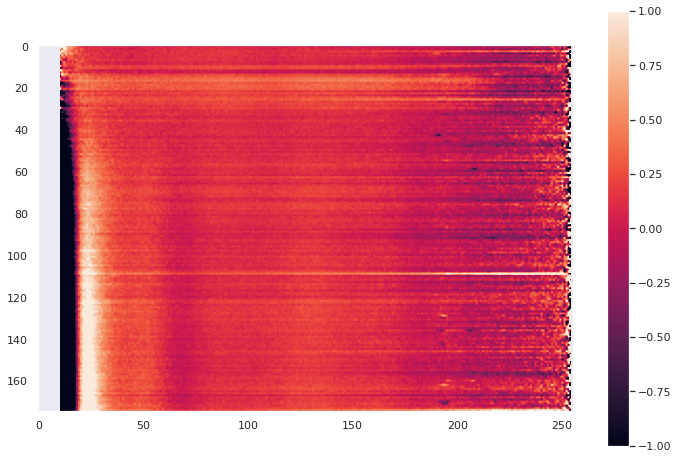

In [143]:
plt.figure(figsize=(12,8))
plt.grid(None)
plt.imshow(remove_I_buff(I_on)-remove_I_buff(I_off), vmax=1,vmin=-1)
plt.colorbar()

In [144]:
np.savetxt("runs_136-165_I_pon-I_poff.csv", remove_I_buff(I_on)-remove_I_buff(I_off), delimiter=",")
np.savetxt("runs_136-165_I_poff.csv", remove_I_buff(I_off), delimiter=",")
np.savetxt("runs_136-165_I_pon.csv", remove_I_buff(I_on), delimiter=",")
np.savetxt("runs_136-165_I_off.csv", I_off, delimiter=",")
np.savetxt("runs_136-165_I_on.csv", I_on, delimiter=",")